In [1]:
import os
import glob
import shutil

import SimpleITK as sitk
import ants

print(f"AntsPy version: {ants.__version__}")
print(f"SimpleITK version: {sitk.__version__}")

AntsPy version: 0.4.2
SimpleITK version: 2.3.1


In [2]:
!pip install ipywidgets


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt

from ipywidgets import interact
import numpy as np
import SimpleITK as sitk


def explore_3D_array(arr: np.ndarray, cmap: str = "gray"):
    """
    Given a 3D array with shape (Z,X,Y) This function will create an interactive
    widget to check out all the 2D arrays with shape (X,Y) inside the 3D array.
    The purpose of this function to visual inspect the 2D arrays in the image.

    Args:
      arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
      cmap : Which color map use to plot the slices in matplotlib.pyplot
    """

    def fn(SLICE):
        plt.figure(figsize=(7, 7))
        plt.imshow(arr[SLICE, :, :], cmap=cmap)

    interact(fn, SLICE=(0, arr.shape[0] - 1))

In [4]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
raw_img_path = os.path.join(
    BASE_DIR,
    "data",
    "preprocess",
    "ADNI1_T1_MRI",
    "3_step_registration",
    "002_S_0619.nii.gz",
)

image = ants.image_read(raw_img_path, reorient="ASR")

In [11]:
print(image)

ANTsImage (ASR)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (218, 182, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, -91.0, 109.0)
	 Direction  : [-0.  0.  1.  1.  0.  0.  0. -1.  0.]



In [12]:
explore_3D_array(arr=image.numpy())

interactive(children=(IntSlider(value=108, description='SLICE', max=217), Output()), _dom_classes=('widget-int…

In [27]:
slice_thickness = None
top_discard = 126
bottom_discard = 94
voxel_resample = (1, 1, 1)


image = ants.image_read(
    raw_img_path, reorient="ASR"
)  # Z, Y, X - IAL = Inferior-to-superior, Anterior-to-posterior, Left-to-right
image_data = image.numpy()  # -> (Z,Y,X)
image_shape = image_data.shape

# Validate slice thickness or calculate based on image size (if no header or slice_thickness provided)
if slice_thickness is None:
    if len(image_shape) != 3:
        raise ValueError("Image data must have 3 dimensions (z, y, x)")
        # Assuming axial slices (z-direction), estimate slice thickness based on total size
    slice_thickness = image.spacing[0]

# Calculate slice indices for extraction
num_slices = image_shape[0]
start_slice = int(bottom_discard / slice_thickness)
end_slice = top_discard

# Extract the desired slices
extracted_data = image_data[start_slice:end_slice, :, :]
extracted_image = ants.from_numpy(extracted_data)

In [28]:
print(extracted_image)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (32, 182, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



In [29]:
mri_image_voxel = ants.resample_image(extracted_image, voxel_resample, False, 1)

In [30]:
print(mri_image_voxel)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (32, 182, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



In [31]:
explore_3D_array(arr=mri_image_voxel.numpy())

interactive(children=(IntSlider(value=15, description='SLICE', max=31), Output()), _dom_classes=('widget-inter…

In [6]:
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))
raw_img_path = os.path.join(
    BASE_DIR,
    "data",
    "preprocess",
    "ADNI1_T1_MRI",
    "5_step_class_folders",
    "GE",
    "AD",
    "002_S_0619.nii.gz",
)

image = ants.image_read(raw_img_path)

In [7]:
explore_3D_array(arr=image.numpy())

interactive(children=(IntSlider(value=15, description='SLICE', max=31), Output()), _dom_classes=('widget-inter…

In [35]:
import numpy as np
import nibabel as nib
from skimage.transform import resize

raw_img_path = os.path.join(
    BASE_DIR,
    "data",
    "preprocess",
    "ADNI1_T1_MRI",
    "6_step_nifti_2d",
    "GE",
    "AD",
    "002_S_0619_slice_0.nii.gz",
)

image_path = raw_img_path
image = nib.load(image_path)
image = np.array(image.get_fdata()[:, :]).squeeze().astype(np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
finish_image = resize(image, (224, 224), mode="constant")

In [36]:
image.shape

(182, 182)

In [37]:
finish_image.shape

(224, 224)

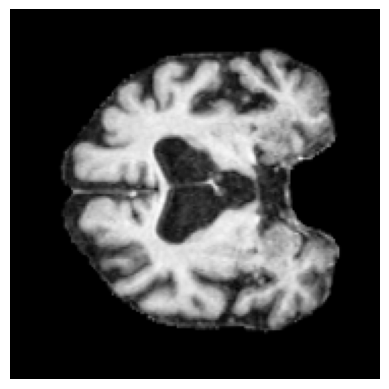

In [38]:
ants.plot(extracted_image)